In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
import re, string
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
data = pd.read_csv('train.csv')

In [4]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
num_class = len(label_cols)
X = data[['comment_text']]
y = data[label_cols]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [7]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s):
    return re_tok.sub(r'\1', s).split()


vec = TfidfVectorizer(tokenizer=tokenize, stop_words={'english'}, max_features=10000,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

In [8]:
vec.fit(X['comment_text'])
train_vec = vec.transform(X_train['comment_text'])
test_vec = vec.transform(X_test['comment_text'])

In [9]:
train_vec.shape, test_vec.shape

((111699, 10000), (47872, 10000))

In [10]:
model = Sequential()
model.add(Dense(1000, input_dim = 10000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dense(num_class, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              10001000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_3 (Dropout)  

In [11]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [12]:
batch_size = 256 
num_epochs = 8 

In [13]:
hist = model.fit(train_vec, y_train, batch_size=batch_size, epochs=num_epochs, 
                 callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 100529 samples, validate on 11170 samples
Epoch 1/8
100529/100529 [==============================] - 160s 2ms/step - loss: 0.0952 - acc: 0.9677 - val_loss: 0.0701 - val_acc: 0.9761
Epoch 2/8
100529/100529 [==============================] - 157s 2ms/step - loss: 0.0548 - acc: 0.9808 - val_loss: 0.0686 - val_acc: 0.9774
Epoch 3/8
100529/100529 [==============================] - 160s 2ms/step - loss: 0.0418 - acc: 0.9845 - val_loss: 0.0741 - val_acc: 0.9766
Epoch 4/8
100529/100529 [==============================] - 151s 1ms/step - loss: 0.0301 - acc: 0.9880 - val_loss: 0.0904 - val_acc: 0.9760
Epoch 5/8
100529/100529 [==============================] - 154s 2ms/step - loss: 0.0237 - acc: 0.9902 - val_loss: 0.0979 - val_acc: 0.9760
Epoch 00005: early stopping


In [14]:
y_pred = model.predict(test_vec)

In [15]:
y_pred

array([[3.5651901e-01, 3.6454201e-02, 2.4459538e-01, 6.3056976e-02,
        2.8945526e-01, 1.3155273e-01],
       [1.9073486e-06, 0.0000000e+00, 1.7881393e-07, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.4323115e-02, 3.0398369e-06, 2.9561520e-03, 1.0788441e-05,
        1.4735162e-03, 2.0721555e-04],
       ...,
       [2.9809684e-02, 1.2695789e-05, 5.3480566e-03, 3.5911798e-05,
        3.4874976e-03, 4.8872828e-04],
       [8.1408024e-04, 0.0000000e+00, 1.5556812e-05, 0.0000000e+00,
        6.2286854e-06, 1.7881393e-07],
       [3.8501620e-04, 0.0000000e+00, 9.0897083e-06, 0.0000000e+00,
        2.7716160e-06, 5.9604645e-08]], dtype=float32)

In [16]:
p = y_pred.round()

In [17]:
p

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [18]:
for i, j in enumerate(label_cols):
    print(j)
    print(confusion_matrix(y_test[j], p[:, i]))
    print(f1_score(y_test[j], p[:, i]))
    print('\n')

toxic
[[42422   868]
 [ 1595  2987]]
0.7080715894275217


severe_toxic
[[47292    94]
 [  373   113]]
0.3261183261183261


obscene
[[44996   320]
 [  948  1608]]
0.7172167707404103


threat
[[47729     7]
 [  124    12]]
0.15483870967741936


insult
[[44679   804]
 [  833  1556]]
0.6552958517582649


identity_hate
[[47358    82]
 [  371    61]]
0.21217391304347824




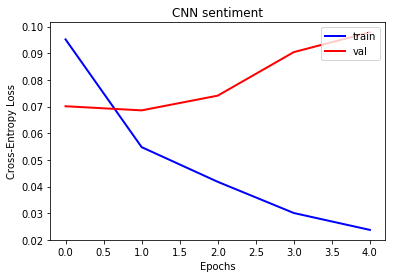

In [19]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

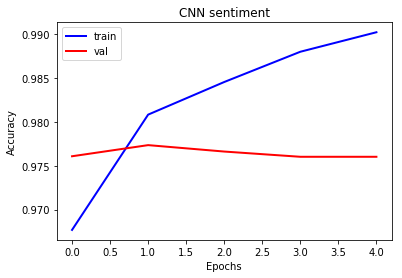

In [20]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()